In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
source_filename = "enron_random_clean1_senders.pkl"
master = pd.read_pickle(source_filename)
master["label"] = master.entity.apply(lambda x: 1 if x == "signature" else 0)

# Feature Selection

In [4]:
excluded_columns = ["line", 
                    "filename", 
                    "entity", 
                    "label", 
                    "nSig", 
                    "firstchar", 
                    'nlines',
                     'len_avg',
                    'len_min',
                    'len_max',
                    'nBlanks',
                    'nNonBlanks',
                    'nSigBlocks',
                    'pred_label',
                    "next_label",
                    "sigToLinesRatio",
                    "pred_file",
                    "next_file",
                    "lineNo",
#                     "len",
                    "pred_named_entity",
                    "named_entity",
                    "next_named_entity",
                    "sender", 
                    "sender_name"
                    
                    
                    
 ]

In [5]:
no_shift_columns = ["prev_same_entity", "next_same_entity"]

In [6]:
def split_df(df):
    filenames = df.filename.unique()
    from sklearn.model_selection import train_test_split
    train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    train = df[df.filename.isin(train_filenames)]
    test = df[df.filename.isin(test_filenames)]
    featured_columns = [c for c in df.columns if c not in excluded_columns]
    X_train = train.loc[:, featured_columns]
    X_test = test.loc[:, featured_columns]
    y_train = train.label
    y_test = test.label
    return X_train, X_test, y_train, y_test, train, test

In [7]:
def shift_df(df):
    prev_val = -1
    next_val = 2
    df["pred_file"] = df.filename.shift(1, fill_value=prev_val)
    df["next_file"] = df.filename.shift(-1, fill_value=next_val)
    columns_to_shift = [c for c in df.columns if c not in excluded_columns and c not in no_shift_columns]
        
    print(f"Columns to shift: {columns_to_shift}")
    for col in columns_to_shift:
        print(f"Shifting columng {col}")
        pred_name = f"prev_{col}"
        df[pred_name] = df[col].shift(1, fill_value=prev_val)
        df[pred_name] = df.apply(lambda row: row[pred_name] if row.pred_file == row.filename else prev_val, axis=1)
        
        next_name = f"next_{col}"
        df[next_name] = df[col].shift(-1, fill_value=next_val)
        df[next_name] = df.apply(lambda row: row[next_name] if row.next_file == row.filename else next_val, axis=1)
    return df

In [13]:
from sklearn import svm
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [8]:
shifted = shift_df(master)

Columns to shift: ['len', 'blank', 'email', 'url', 'phone', 'sigdelimiter', 'special', 'words', 'header', 'name', 'endquote', 'tabs1', 'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90', 'reply', 'startpunct', 'replypunct', 'wrote', 'alphanum90', 'alphanum50', 'alphanum10', 'num90', 'num50', 'num10', 'title', 'many_titles', 'person', 'org', 'posFromEnd', 'last', 'prevlast', 'last5', 'last11', 'posRatio', 'posRatioFromEnd', 'posRatioNB', 'lenRatio', 'lenRatioMax', 'less_avg_len', 'more_avg_len', 'less_avg_len75', 'less_avg_len50', 'has_sender', 'has_sender_name']
Shifting columng len
Shifting columng blank
Shifting columng email
Shifting columng url
Shifting columng phone
Shifting columng sigdelimiter
Shifting columng special
Shifting columng words
Shifting columng header
Shifting columng name
Shifting columng endquote
Shifting columng tabs1
Shifting columng tabs2
Shifting columng tabs3
Shifting columng punct20
Shifting columng punct50
Shifting columng punct90
Shifting columng reply
Shif

# Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold

In [20]:
parameters = {
    'C': [0.002, 0.07, 0.1, 0.5, 1, 1.25, 1.5, 2, 10, 12, 16, 32, 64, 0.047, 0.052, 0.057, 0.062, 0.067, 0.1, 0.5, 1, 1.25, 1.5, 2],
#     'C': [0.002, 0.07, 0.1, 0.5, 1, 1.25, 1.5, 2, 10, 12],
    'class_weight': [{1: 1}, {1: 2}, {1: 2.5}, {1: 2.25}, {1: 3}, {1: 5}]
}

In [64]:
X_train, X_test, y_train, y_test, train, test = split_df(shifted)

In [31]:
svc = svm.LinearSVC(random_state=42, dual=True, max_iter=100000)
clf = GridSearchCV(svc, parameters, scoring="f1", cv=GroupKFold(n_splits=10), n_jobs=-1, refit=False, verbose=10)
clf.fit(X_train, y_train, groups=train.filename)

print(f"Best score: {clf.best_score_:.3}")
print()
print(f"Best params: {clf.best_params_}")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Best score: 0.748

Best params: {'C': 2, 'class_weight': {1: 1}}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 16.3min finished


In [33]:
X_train.columns

Index(['len', 'blank', 'email', 'url', 'phone', 'sigdelimiter', 'special',
       'words', 'header', 'name',
       ...
       'prev_more_avg_len', 'next_more_avg_len', 'prev_less_avg_len75',
       'next_less_avg_len75', 'prev_less_avg_len50', 'next_less_avg_len50',
       'prev_has_sender', 'next_has_sender', 'prev_has_sender_name',
       'next_has_sender_name'],
      dtype='object', length=143)

# Test score

In [9]:
X_train, X_test, y_train, y_test, train, test = split_df(shifted)

In [17]:
from imblearn.over_sampling import SMOTE
shifted["filename_cat"] = shifted.filename.astype('category')
X_train, X_test, y_train, y_test, train, test = split_df(shifted)
# Add temporarily
X_train["label"] = train.label
X_train["nSigBlocks"] = train.nSigBlocks
X_train["filename_code"] = train.filename_cat.cat.codes

# Apply smote
sm = SMOTE(random_state=42, sampling_strategy=.4)
X_train, y_train_nSigBlocks = sm.fit_resample(X_train, train.nSigBlocks)
y_train = X_train.label

# After SMOTE
print("Afer SMOTE:")
print(X_train.nSigBlocks.value_counts())
print(X_train.nSigBlocks.value_counts(normalize=True))

# Cleanup
train_filenames = X_train["filename_code"]
X_train.drop(["label", "filename_code", "nSigBlocks"], axis=1, inplace=True)

assert "label" not in X_train.columns
assert "filename_code" not in X_train.columns
assert len(y_train) == len(X_train)

ValueError: could not convert string to float: 'allen-p_all_documents_113.txt'

In [15]:
linear = svm.LinearSVC(C=0.07, random_state=42, dual=True, class_weight={1: 1}, max_iter=100000)
linear.fit(X_train, y_train)
linear_pred = linear.predict(X_test)
print(f1_score(y_true=y_test, y_pred=linear_pred))

print()
print(classification_report(y_true=y_test, y_pred=linear_pred, digits=3))

0.7559055118110236

              precision    recall  f1-score   support

           0      0.984     0.971     0.977       692
           1      0.706     0.814     0.756        59

    accuracy                          0.959       751
   macro avg      0.845     0.892     0.867       751
weighted avg      0.962     0.959     0.960       751



In [340]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(20,65))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.grid()
    plt.savefig("coef_bars.png")
    plt.show()

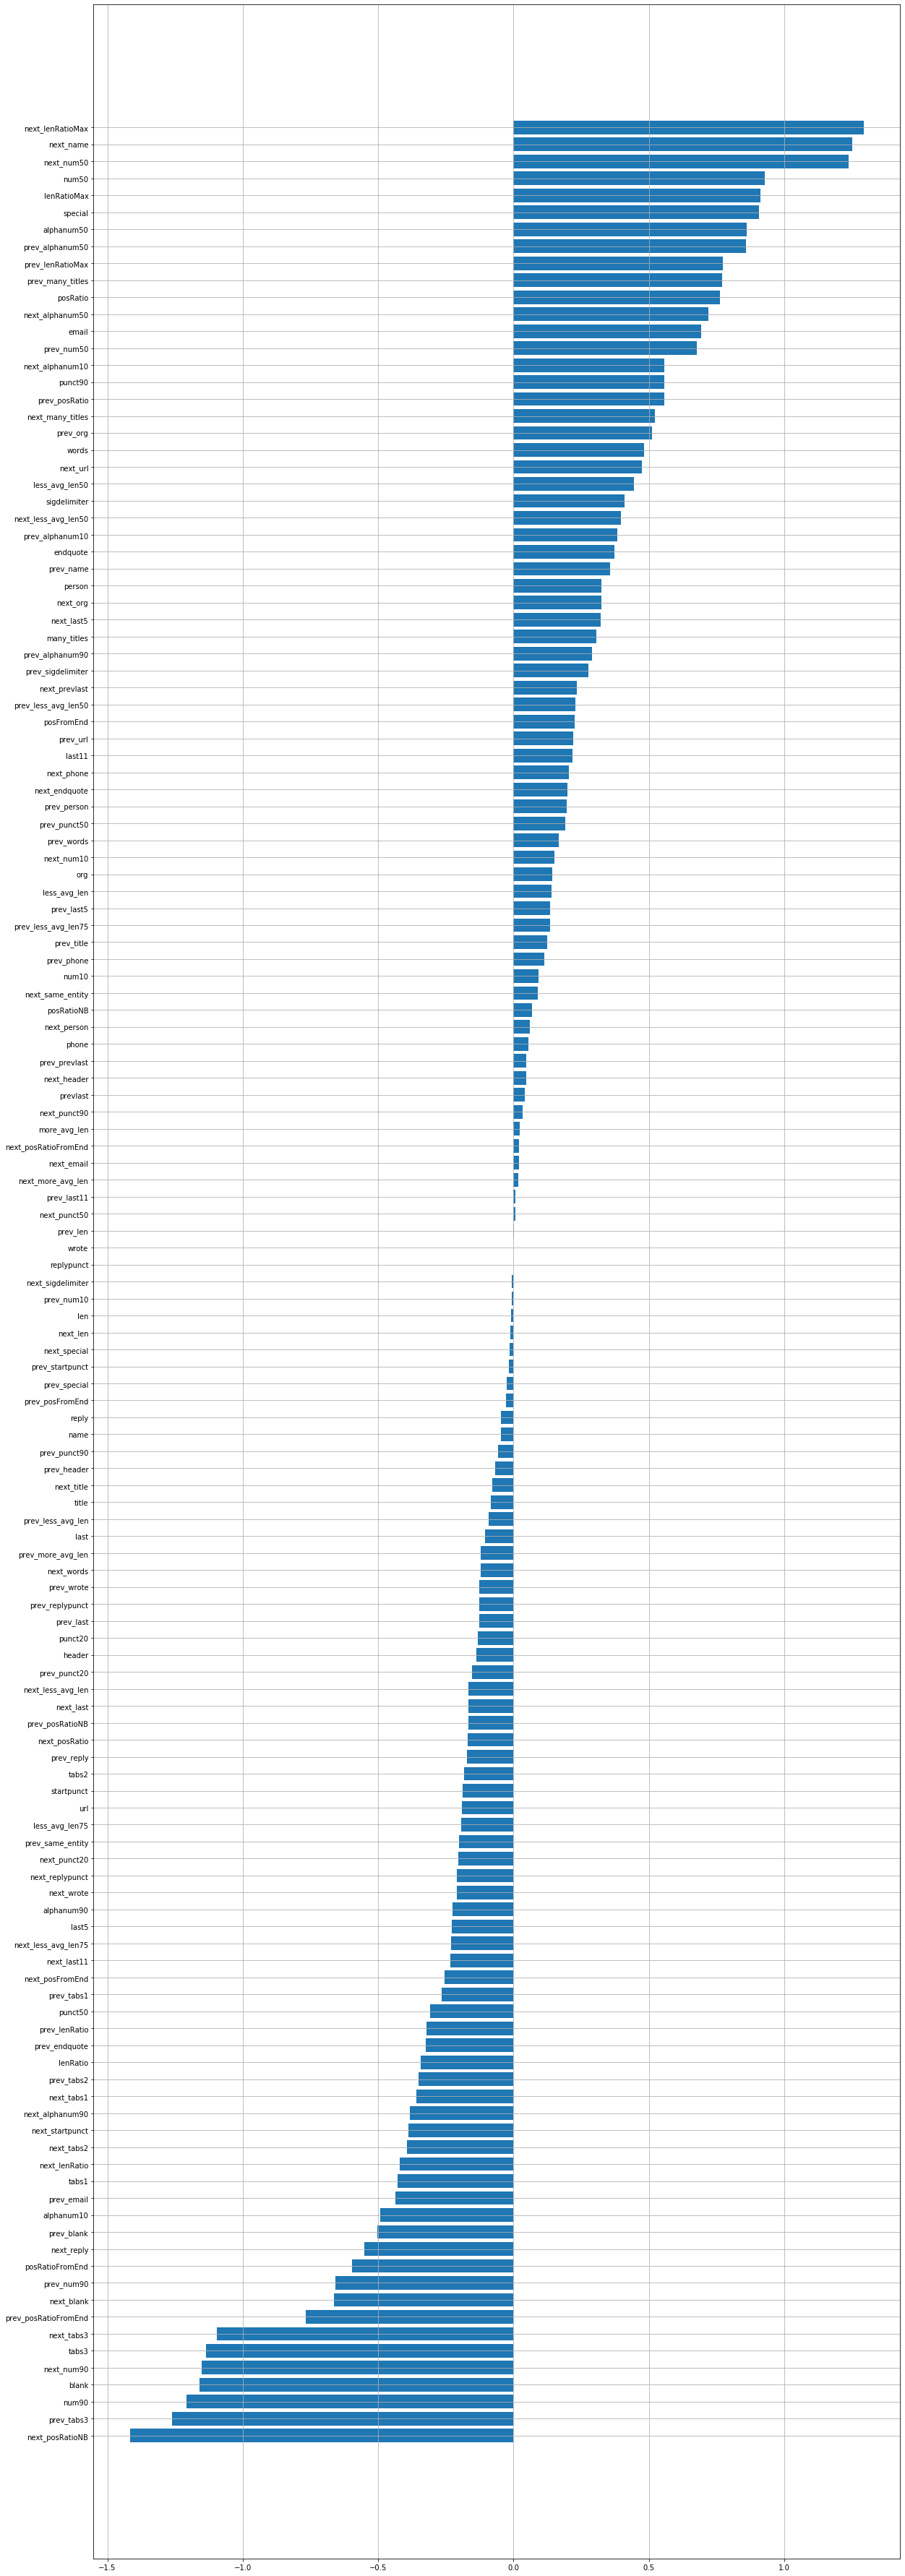

In [341]:
f_importances(linear.coef_[0], X_train.columns)

In [197]:
print(confusion_matrix(y_test, linear_pred))

[[541  38]
 [ 12  41]]


In [70]:
test["pred"] = linear_pred
TP = test[(test.label == 1) & (test.pred == 1)] # is signature and predicted signature
TN = test[(test.label == 0) & (test.pred == 0)] # is not signature and predicted not signature

FP = test[(test.label == 0) & (test.pred == 1)] # is not signature but predicted signature
FN = test[(test.label == 1) & (test.pred == 0)] # is signature but predicted not signature

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [166]:
print(f"TP len mean: {TP.len.mean()}")
print(f"TN len mean: {TN.len.mean()}")
print(f"FP len mean: {FP.len.mean()}")
print(f"FN len mean: {FN.len.mean()}")

TP len mean: 9.975609756097562
TN len mean: 51.65596330275229
FP len mean: 24.31578947368421
FN len mean: 10.166666666666666


In [38]:
def update_prediction(row):
    same_file = row.pred_file == row.filename and row.next_file == row.filename
    if not same_file:
        return row.pred
    
    if row.pred_predict == 1 and row.next_predict == 1:
        return 1
    if row.pred_predict == 0 and row.next_predict == 0:
        return 0
        
    return row.pred

# Improve with blocking

In [71]:
test["pred_predict"] = test.pred.shift(1)
test["next_predict"] = test.pred.shift(-1)
test["pred_file"] = test.filename.shift(1)
test["next_file"] = test.filename.shift(-1)
test["new_pred"] = test.apply(lambda row: update_prediction(row), axis=1)

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [72]:
print(f1_score(y_true=test.label, y_pred=test.new_pred))

0.9544787077826724


In [73]:
print(f1_score(y_true=test.label, y_pred=test.pred))

0.9476014760147601


In [74]:
print(f"Precision with blocking: {precision_score(y_true=test.label, y_pred=test.new_pred):.2f}")
print(f"Recall with blocking: {recall_score(y_true=test.label, y_pred=test.new_pred):.2f}")
print(f"F1 with blocking: {f1_score(y_true=test.label, y_pred=test.new_pred):.2f}")

Precision with blocking: 0.94
Recall with blocking: 0.97
F1 with blocking: 0.95
